 1: Classification

In [9]:
import kagglehub

data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print("Path to dataset files:", data_dir)

Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [3]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [4]:
# Dataset Class
class ImageDataset(Dataset):

    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(img_name)
                else:
                    print(f"Image {img_name} has multiple objects and will be excluded from the dataset")
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label = self.parse_annotation(annotation_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        label = None
        for obj in root.findall("object"):
            name = obj.find("name").text
            if label is None:
                label = name  # Take the first label for now

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num

In [5]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Image Cats_Test736.png has multiple objects and will be excluded from the dataset
Image Cats_Test736.png has multiple objects and will be excluded from the dataset


In [7]:
# Model
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat and dog

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Show model summary
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)

            scores = model(data)
            _, predictions = scores.max(1)

            correct += (predictions == targets).sum()
            total += targets.size(0)

        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct)/float(total)*100:.2f}%')

Epoch 1/10, Validation Accuracy: 93.63%
Epoch 2/10, Validation Accuracy: 92.55%
Epoch 3/10, Validation Accuracy: 91.73%
Epoch 4/10, Validation Accuracy: 92.55%
Epoch 5/10, Validation Accuracy: 64.91%
Epoch 6/10, Validation Accuracy: 89.57%
Epoch 7/10, Validation Accuracy: 84.96%
Epoch 8/10, Validation Accuracy: 82.93%
Epoch 9/10, Validation Accuracy: 95.39%
Epoch 10/10, Validation Accuracy: 94.17%


2: Classification + Bounding Box Regression

In [10]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [2]:
# Dataset Class
class ImageDataset(Dataset):

    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object'):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Image path
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        image = Image.open(img_path).convert("RGB")

        # Annotation path
        annotation_name = os.path.splitext(img_name)[0] + ".xml"
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # Parse annotation
        label, bbox = self.parse_annotation(annotation_path)  # Get both label and bbox

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label, bbox

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find('size/width').text)
        image_height = int(root.find('size/height').text)

        label = None
        bbox = None
        for obj in root.findall('object'):
            name = obj.find('name').text
            if label is None:  # Take the first label
                label = name

            # Get bounding box coordinates
            xmin = int(obj.find('bndbox/xmin').text)
            ymin = int(obj.find('bndbox/ymin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymax = int(obj.find('bndbox/ymax').text)

            # Normalize bbox coordinates to [0, 1]
            bbox = [
                xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height,
            ]

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

In [3]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Get list of image files and create a dummy dataframe to split the data
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})

# Split data
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Datasets
train_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform=transform)

# Filter datasets based on train_df and val_df
train_dataset.image_files = [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files = [f for f in val_dataset.image_files if f in val_df['image_name'].values]

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [5]:
# Model with Two Heads
class TwoHeadedModel(nn.Module):
    def __init__(self, num_classes=2):
        super(TwoHeadedModel, self).__init__()
        self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.num_ftrs = self.base_model.fc.in_features

        # Remove the original fully connected layer
        self.base_model.fc = nn.Identity()

        # Classification head
        self.classifier = nn.Linear(self.num_ftrs, num_classes)

        # Bounding box regression head
        self.regressor = nn.Linear(self.num_ftrs, 4)

    def forward(self, x):
        x = self.base_model(x)
        class_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.regressor(x))
        return class_logits, bbox_coords

In [6]:
# Model
model = TwoHeadedModel()

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and Optimizer
criterion_class = nn.CrossEntropyLoss()  # For classification head
criterion_bbox = nn.MSELoss()            # For bounding box regression head

optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 84.3MB/s]


In [7]:
# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()

    for batch_idx, (data, targets, bboxes) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        bboxes = bboxes.to(device)

        # Forward pass
        scores, pred_bboxes = model(data)

        # Compute losses
        loss_class = criterion_class(scores, targets)
        loss_bbox = criterion_bbox(pred_bboxes, bboxes)
        loss = loss_class + loss_bbox  # Combine losses

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        total_loss_bbox = 0
        total_samples = 0

        for data, targets, bboxes in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            bboxes = bboxes.to(device)

            # Forward pass
            scores, pred_bboxes = model(data)
            _, predictions = scores.max(1)

            # Accuracy calculation
            correct += (predictions == targets).sum()
            total += targets.size(0)

            # Calculate bounding box loss (optional)
            total_loss_bbox += criterion_bbox(pred_bboxes, bboxes).item() * data.size(0)
            total_samples += data.size(0)

        avg_loss_bbox = total_loss_bbox / total_samples

    # Print validation results
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {float(correct) / float(total) * 100:.2f}%, '
          f'Avg. Bbox Loss: {avg_loss_bbox:.4f}')

Epoch 1/10, Validation Accuracy: 91.60%, Avg. Bbox Loss: 0.0185
Epoch 2/10, Validation Accuracy: 93.63%, Avg. Bbox Loss: 0.0126
Epoch 3/10, Validation Accuracy: 93.50%, Avg. Bbox Loss: 0.0122
Epoch 4/10, Validation Accuracy: 96.75%, Avg. Bbox Loss: 0.0083
Epoch 5/10, Validation Accuracy: 92.55%, Avg. Bbox Loss: 0.0112
Epoch 6/10, Validation Accuracy: 94.31%, Avg. Bbox Loss: 0.0118
Epoch 7/10, Validation Accuracy: 96.48%, Avg. Bbox Loss: 0.0096
Epoch 8/10, Validation Accuracy: 94.44%, Avg. Bbox Loss: 0.0082
Epoch 9/10, Validation Accuracy: 96.34%, Avg. Bbox Loss: 0.0072
Epoch 10/10, Validation Accuracy: 94.31%, Avg. Bbox Loss: 0.0077


3: Classification (> 2 objects in an image) + Bounding Box Regression

In [11]:
import os
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import tqdm.notebook as tqdm

from PIL import Image
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights, ResNet50_Weights

In [12]:
class MyDataset(Dataset):
    def __init__(self, annotations_dir, image_dir, transform=None):
        self.annotations_dir = annotations_dir
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = self.filter_images_with_multiple_objects()

    def filter_images_with_multiple_objects(self):
        valid_image_files = []
        for f in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, f)):
                img_name = f
                annotation_name = os.path.splitext(img_name)[0] + ".xml"
                annotation_path = os.path.join(self.annotations_dir, annotation_name)

                if self.count_objects_in_annotation(annotation_path) == 1:
                    valid_image_files.append(img_name)
        return valid_image_files

    def count_objects_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall("object"):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        # Get image size for normalization
        image_width = int(root.find("size/width").text)
        image_height = int(root.find("size/height").text)

        label = None
        bbox = None
        for obj in root.findall("object"):
            name = obj.find("name").text
            if label is None:  # Take the first label
                label = name

            # Get bounding box coordinates
            xmin = int(obj.find("bndbox/xmin").text)
            ymin = int(obj.find("bndbox/ymin").text)
            xmax = int(obj.find("bndbox/xmax").text)
            ymax = int(obj.find("bndbox/ymax").text)

            # Normalize bbox coordinates to [0, 1]
            bbox = [
                xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height,
            ]

        # Convert label to numerical representation (0 for cat, 1 for dog)
        label_num = 0 if label == "cat" else 1 if label == "dog" else -1

        return label_num, torch.tensor(bbox, dtype=torch.float32)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load first image and annotation
        img1_file = self.image_files[idx]
        img1_path = os.path.join(self.image_dir, img1_file)
        annotation_name = os.path.splitext(img1_file)[0] + ".xml"
        img1_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation_name))

        # Load second image and annotation randomly
        #idx2 = random.randint(0, len(self.image_files) - 1)
        img2_file = self.image_files[idx2]
        img2_path = os.path.join(self.image_dir, img2_file)
        annotation_name = os.path.splitext(img2_file)[0] + ".xml"
        img2_annotations = self.parse_annotation(os.path.join(self.annotations_dir, annotation_name))

        # Open both images
        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        # Horizontal merge of two images
        merged_image = Image.new("RGB", (img1.width + img2.width, max(img1.height, img2.height)))
        merged_image.paste(img1, (0, 0))
        merged_image.paste(img2, (img1.width, 0))
        merged_w = img1.width + img2.width
        merged_h = max(img1.height, img2.height)

        merged_annotations = []

        # No change for objects from img1
        merged_annotations.append({"bbox": img1_annotations[1], "label": img1_annotations[0]})

        # Adjust bbox coordinates for objects from img2
        new_bbox = [
            img2_annotations[1][0] + img1.width,
            img2_annotations[1][1],
            img2_annotations[1][2] + img1.width,
            img2_annotations[1][3]
        ]
        merged_annotations.append({"bbox": new_bbox, "label": img2_annotations[0]})

        # Split the merged image into 4 patches
        patch_width = merged_w // 2
        patch_height = merged_h // 2
        patches = []
        patch_annotations = []  # list of dictionaries

        for i in range(2):
            for j in range(2):
                left = j * patch_width
                upper = i * patch_height
                right = (j + 1) * patch_width
                lower = (i + 1) * patch_height

                patch = merged_image.crop((left, upper, right, lower))
                patches.append(patch)

                # Initialize annotation list for the current patch
                current_patch_annotations = []
                for anno in merged_annotations:
                    center_x, center_y = calculate_center(anno["bbox"])

                    # Check if the center of the ground truth bbox is within the patch
                    if left <= center_x < right and upper <= center_y < lower:
                        current_patch_annotations.append({
                        "bbox": anno["bbox"],
                        "label": anno["label"]
                        })
                        break

                  # Add a dummy bounding box if no object is in the patch
                if len(current_patch_annotations) == 0:
                    current_patch_annotations.append({
                    "bbox": [0, 0, 0, 0],  # Dummy bbox
                    "label": 0  # Dummy label
                    })

                patch_annotations.append(current_patch_annotations[0])

        # Transform and convert to tensors
        if self.transform:
            patches = [self.transform(patch) for patch in patches]

        patches = torch.stack(patches)  # Shape: (4, C, H, W)
        patch_annotations = [
            {
            "bbox": torch.tensor(patch["bbox"], dtype=torch.float32),
            "label": torch.tensor(patch["label"], dtype=torch.long)
            }
            for patch in patch_annotations
            ]

        return patches, patch_annotations

# Helper function to calculate the center of a bounding box
def calculate_center(bbox):
    return ((bbox[0] + bbox[2]) / 2, (bbox[1] + bbox[3]) / 2)

In [13]:
# Data directory
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and dataloaders
dataset = MyDataset(annotations_dir, image_dir, transform=transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

<ipython-input-12-5c21bb3b880a>:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "bbox": torch.tensor(patch["bbox"], dtype=torch.float32),


In [14]:
class SimpleYOLO(nn.Module):
    def __init__(self, num_classes):
        super(SimpleYOLO, self).__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.num_classes = num_classes

        # Remove the final classification layer of ResNet
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])

        # Adaptive average pooling for classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Separate heads for each patch
        self.classifiers = nn.ModuleList([nn.Linear(2048, num_classes) for _ in range(4)])
        self.regressors = nn.ModuleList([nn.Linear(2048, 4) for _ in range(4)])  # 4 values for bbox

    def forward(self, x):
        # x shape: (batch_size, 4, C, H, W) -> 4 patches
        batch_size = x.shape[0]
        features = []

        # Extract features for each patch
        for i in range(4):
            patch_features = self.backbone(x[:, i, :, :, :])  # (batch_size, C, H, W)
            features.append(patch_features)

        class_outputs = []
        reg_outputs = []

        for i in range(4):
            # Classification head
            class_feat = self.avgpool(features[i]).view(batch_size, -1)  # Global average pooling
            class_output = self.classifiers[i](class_feat)
            class_outputs.append(class_output)

            # Regression head
            reg_output = self.regressors[i](features[i].mean(dim=[2, 3]))
            reg_outputs.append(reg_output)

        return class_outputs, reg_outputs  # Return list of tensors with length = 4


In [15]:
# Initialize model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 2  # Assuming two classes: dog and cat
class_to_idx = {'dog': 0, 'cat': 1}

# Initialize the model
model = SimpleYOLO(num_classes=num_classes).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


In [16]:
def calculate_loss(class_outputs, reg_outputs, targets, device, num_classes):
    class_to_idx = {'dog': 0, 'cat': 1}
    total_loss = 0

    for i in range(4):  # Loop through each patch
        # Convert class targets to one-hot encoding
        class_targets_tensor = F.one_hot(targets[i]['label'], num_classes=num_classes).to(device).float()
        bbox_targets_tensor = targets[i]['bbox'].to(device)

        # Classification Loss
        if len(class_targets_tensor) > 0:
            classification_loss = nn.MSELoss()(class_outputs[i], class_targets_tensor)
        else:
            classification_loss = torch.tensor(0.0, device=device)

        # Regression Loss
        if len(bbox_targets_tensor) > 0:
            regression_loss = nn.MSELoss()(reg_outputs[i], bbox_targets_tensor)
        else:
            regression_loss = torch.tensor(0.0, device=device)

        # Combine classification and regression losses
        total_loss += classification_loss + regression_loss

    return total_loss

def evaluate_model(model, data_loader, device, num_classes, class_to_idx):
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for patches, patch_annotations in data_loader:
            patches = patches.to(device)

            # Forward pass
            class_outputs, reg_outputs = model(patches)

            # Calculate total loss
            total_loss = calculate_loss(class_outputs, reg_outputs, patch_annotations, device, num_classes)

            # Calculate accuracy
            for i in range(4):
                class_predictions = class_outputs[i].argmax(dim=1)
                class_targets = patch_annotations[i]['label']
                correct_val += (class_predictions == class_targets.to(device)).sum().item()

            total_val += len(class_targets)
            running_loss += total_loss.item()

    val_loss = running_loss / len(data_loader)
    val_accuracy = correct_val / total_val if total_val > 0 else 0

    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, num_classes, class_to_idx):
    best_val_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for patches, patch_annotations in tqdm.tqdm(train_loader):
            patches = patches.to(device)

            optimizer.zero_grad()
            class_outputs, reg_outputs = model(patches)

            total_loss = calculate_loss(class_outputs, reg_outputs, patch_annotations, device, num_classes)

            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        val_loss, val_accuracy = evaluate_model(model, val_loader, device, num_classes, class_to_idx)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
num_epochs = 10

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, optimizer, num_epochs, device, num_classes, class_to_idx
)

  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 1/10, Train Loss: 37441.2309, Validation Loss: 27655.8696, Validation Accuracy: 2.9159


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 2/10, Train Loss: 26365.1694, Validation Loss: 26675.4921, Validation Accuracy: 3.1682


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 3/10, Train Loss: 25867.1671, Validation Loss: 26581.3120, Validation Accuracy: 3.2266


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 4/10, Train Loss: 24966.9153, Validation Loss: 28093.6365, Validation Accuracy: 3.1194


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 5/10, Train Loss: 25742.7402, Validation Loss: 27679.5228, Validation Accuracy: 3.1533


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 6/10, Train Loss: 24809.8210, Validation Loss: 26523.6516, Validation Accuracy: 3.2266


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 7/10, Train Loss: 24754.2536, Validation Loss: 28184.5947, Validation Accuracy: 3.0611


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 8/10, Train Loss: 25197.8571, Validation Loss: 28571.0038, Validation Accuracy: 3.2307


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 9/10, Train Loss: 25450.3574, Validation Loss: 26120.6914, Validation Accuracy: 3.2483


  0%|          | 0/369 [00:00<?, ?it/s]

Epoch 10/10, Train Loss: 25034.9551, Validation Loss: 27042.8009, Validation Accuracy: 3.0244


<ipython-input-17-df62f2166c0f>:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


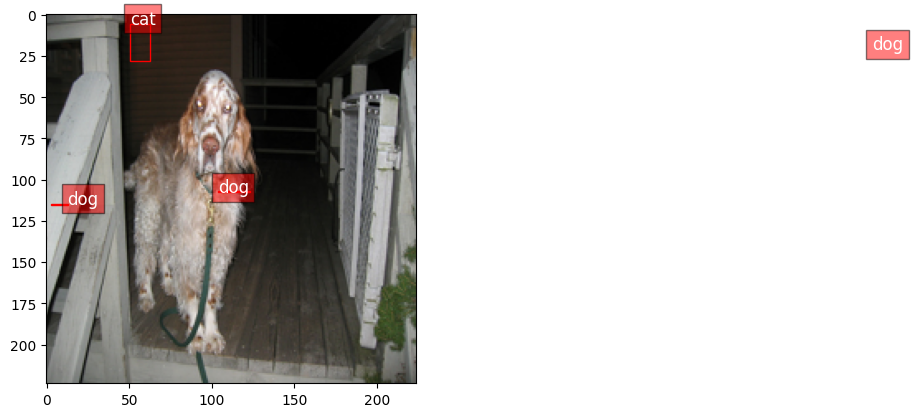

In [17]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Resize the image to match the input size expected by the model
    resized_image = image.resize((224, 224))

    # Apply the same transformations used during training
    transformed_image = transform(resized_image).unsqueeze(0).to(device)

    # Split the image into 4 patches
    patch_width = transformed_image.shape[3] // 2
    patch_height = transformed_image.shape[2] // 2
    image_patches = []

    for i in range(2):
        for j in range(2):
            left = j * patch_width
            upper = i * patch_height
            right = (j + 1) * patch_width
            lower = (i + 1) * patch_height

            patch = transformed_image[0, :, upper:lower, left:right].unsqueeze(0)
            image_patches.append(patch)

    # Combine patches into a single tensor
    image_patches = torch.cat(image_patches, dim=0).unsqueeze(0)

    with torch.no_grad():
        # Forward pass through the model
        class_outputs, reg_outputs = model(image_patches)

    # Plot the original image
    fig, ax = plt.subplots(1)
    ax.imshow(resized_image)

    # Process predictions for each patch
    for i in range(4):
        # Get the class prediction and bounding box for the current patch
        class_pred = class_outputs[i].argmax(dim=1).item()
        bbox = reg_outputs[i].squeeze().tolist()

        # Scale the bounding box back to the original image size
        x_min = min(bbox[0] * patch_width + (i % 2) * patch_width, original_width)
        y_min = min(bbox[1] * patch_height + (i // 2) * patch_height, original_height)
        x_max = max(bbox[2] * patch_width + (i % 2) * patch_width, 0)
        y_max = max(bbox[3] * patch_height + (i // 2) * patch_height, 0)

        # Draw the bounding box and label on the image if the prediction is above the threshold
        if class_outputs[i].max().item() > threshold:
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x_min, y_min,
                     f'{list(class_to_idx.keys())[class_pred]}',
                     color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()


# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Perform inference on a test image
image_path = os.path.join(image_dir, 'Cats_Test431.png')
inference(model, image_path, transform, device, class_to_idx)

4: YOLOv1

In [18]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import Counter
import cv2
from glob import glob
from tqdm import tqdm
from termcolor import colored

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [19]:
class CustomVOCDataset(torchvision.datasets.VOCDetection):
    def init_config_yolo(self, class_mapping, S=7, B=2, C=20, custom_transforms=None):
        # Initialize YOLO-specific configuration parameters
        self.S = S  # Grid size S x S
        self.B = B  # Number of bounding boxes
        self.C = C  # Number of classes
        self.class_mapping = class_mapping  # Mapping of class names to class indices
        self.custom_transforms = custom_transforms

    def __getitem__(self, index):
        # Get an image and its target (annotations) from the VOC dataset
        image, target = super(CustomVOCDataset, self).__getitem__(index)
        img_width, img_height = image.size

        # Convert target annotations to YOLO format bounding boxes
        boxes = convert_to_yolo_format(target, img_width, img_height, self.class_mapping)
        just_boxes = boxes[:, 1:]
        labels = boxes[:, 0]

        # Apply custom transformations if provided
        if self.custom_transforms:
            sample = {
                'image': np.array(image),
                'bboxes': just_boxes,
                'labels': labels
            }
            sample = self.custom_transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']

        # Create an empty label matrix for YOLO ground truth
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.float32)
        image = torch.as_tensor(image, dtype=torch.float32)

        # Iterate through each bounding box in YOLO format
        for box, class_label in zip(boxes, labels):
            x, y, width, height = box.tolist()
            class_label = int(class_label)

            # Calculate the grid cell (i, j) that this box belongs to
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            # Calculate the width and height of the box relative to the grid cell
            width_cell, height_cell = width * self.S, height * self.S

            # If no object has been found in this specific cell (i, j) before
            if label_matrix[i, j, 20] == 0:
                # Mark that an object exists in this cell
                label_matrix[i, j, 20] = 1

                # Store the box coordinates as an offset from the cell boundaries
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])

                # Set the box coordinates in the label matrix
                label_matrix[i, j, 21:25] = box_coordinates

                # Set the one-hot encoding for the class label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [20]:
def convert_to_yolo_format(target, img_width, img_height, class_mapping):
    """
    Convert annotation data from VOC format to YOLO format.

    Parameters:
        target (dict): Annotation data from VOCDetection dataset.
        img_width (int): Width of the original image.
        img_height (int): Height of the original image.
        class_mapping (dict): Mapping from class names to integer IDs.

    Returns:
        torch.Tensor: Tensor of shape [N, 5] for N bounding boxes,
                      each with [class_id, x_center, y_center, width, height].
    """
    # Extract the list of annotations from the target dictionary
    annotations = target['annotation']['object']

    # Get the real width and height of the image from the annotation
    real_width = int(target['annotation']['size']['width'])
    real_height = int(target['annotation']['size']['height'])

    # Ensure that annotations is a list, even if there's only one object
    if not isinstance(annotations, list):
        annotations = [annotations]

    # Initialize an empty list to store the converted bounding boxes
    boxes = []

    # Loop through each annotation and convert it to YOLO format
    for anno in annotations:
        # Normalize bounding box coordinates
        xmin = int(anno['bndbox']['xmin']) / real_width
        xmax = int(anno['bndbox']['xmax']) / real_width
        ymin = int(anno['bndbox']['ymin']) / real_height
        ymax = int(anno['bndbox']['ymax']) / real_height

        # Calculate the center coordinates, width, and height of the bounding box
        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2
        width = xmax - xmin
        height = ymax - ymin

        # Retrieve the class name from the annotation and map it to an integer ID
        class_name = anno['name']
        class_id = class_mapping[class_name] if class_name in class_mapping else 0

        # Append the YOLO formatted bounding box to the list
        boxes.append([class_id, x_center, y_center, width, height])

    # Convert the list of boxes to a numpy array
    return np.array(boxes)

In [21]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculate the Intersection over Union (IoU) between bounding boxes.

    Parameters:
        boxes_preds (tensor): Predicted bounding boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Ground truth bounding boxes (BATCH_SIZE, 4)
        box_format (str): Box format, can be "midpoint" or "corners".

    Returns:
        tensor: Intersection over Union scores for each example.
    """

    # Check if the box format is "midpoint"
    if box_format == "midpoint":
        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2) points for predicted boxes
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        # Calculate coordinates of top-left (x1, y1) and bottom-right (x2, y2) points for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    # Check if the box format is "corners"
    elif box_format == "corners":
        # Extract coordinates for predicted boxes
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        # Extract coordinates for ground truth boxes
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    # Calculate coordinates of the intersection rectangle
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Compute the area of the intersection rectangle, clamp(0) to handle cases where they do not overlap
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Calculate the areas of the predicted and ground truth boxes
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # Calculate the Intersection over Union, adding a small epsilon to avoid division by zero
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [22]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Perform Non-Maximum Suppression on a list of bounding boxes.

    Parameters:
        bboxes (list): List of bounding boxes, each represented as
                       [class_pred, prob_score, x1, y1, x2, y2] or [class_pred, prob_score, x_center, y_center, width, height].
        iou_threshold (float): IoU threshold to determine correct predicted bounding boxes.
        threshold (float): Threshold to discard predicted bounding boxes (independent of IoU).
        box_format (str): "midpoint" or "corners" to specify the format of bounding boxes.

    Returns:
        list: List of bounding boxes after performing NMS with a specific IoU threshold.
    """

    # Check the data type of the input parameter
    assert type(bboxes) == list

    # Filter predicted bounding boxes based on the probability threshold
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sort bounding boxes by probability in descending order
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # List to store bounding boxes after NMS
    bboxes_after_nms = []

    # Continue looping until the list of bounding boxes is empty
    while bboxes:
        # Get the bounding box with the highest probability
        chosen_box = bboxes.pop(0)

        # Remove bounding boxes with IoU greater than the specified threshold with the chosen box
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0] or
               intersection_over_union(
                   torch.tensor(chosen_box[2:]),
                   torch.tensor(box[2:]),
                   box_format=box_format
               ) < iou_threshold
        ]

        # Add the chosen bounding box to the list after NMS
        bboxes_after_nms.append(chosen_box)

    # Return the list of bounding boxes after NMS
    return bboxes_after_nms

In [23]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20):
    """
    Calculate the mean average precision (mAP).

    Parameters:
        pred_boxes (list): A list containing predicted bounding boxes with each box defined as
                           [train_idx, class_pred, prob_score, x1, y1, x2, y2].
        true_boxes (list): A list containing ground truth bounding boxes in the same format as pred_boxes.
        iou_threshold (float): IoU threshold where predicted boxes are considered correct.
        box_format (str): "midpoint" or "corners" format to specify bounding box format.
        num_classes (int): Number of classes.

    Returns:
        float: The mAP value across all classes with a specific IoU threshold.
    """

    # List to store mAP for each class
    average_precisions = []

    # Small epsilon to stabilize division
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Iterate through all predictions and targets for the current class
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # Count the number of boxes for each training example
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # Sort by box probability (index 2 is the probability)
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If no ground truth boxes exist, continue
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Consider ground truth boxes with the same training index
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # Detect ground truth only once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1  # Mark as seen
                else:
                    FP[detection_idx] = 1  # Already detected
            else:
                FP[detection_idx] = 1  # IoU lower than threshold → False Positive

        # Cumulative sum for TP and FP
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)

        # Calculate precision and recall
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        # Add starting points for numerical integration
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))

        # Use trapezoidal rule for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [24]:
"""
Information about the architectural configuration:
A Tuple is structured as (kernel_size, number of filters, stride, padding).
"M" simply represents max-pooling with a 2x2 pool size and 2x2 kernel.
The list is structured according to the data blocks, and ends with an integer
representing the number of repetitions.
"""

# Describing convolutional and max-pooling layers, as well as the number of
# repetitions for convolutional blocks.
architecture_config = [
    (7, 64, 2, 3),  # Convolutional block 1
    "M",            # Max-pooling layer 1
    (3, 192, 1, 1), # Convolutional block 2
    "M",            # Max-pooling layer 2
    (1, 128, 1, 0), # Convolutional block 3
    (3, 256, 1, 1), # Convolutional block 4
    (1, 256, 1, 0), # Convolutional block 5
    (3, 512, 1, 1), # Convolutional block 6
    "M",            # Max-pooling layer 3
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],  # Convolutional block 7 (repeated 4 times)
    (1, 512, 1, 0), # Convolutional block 8
    (3, 1024, 1, 1),# Convolutional block 9
    "M",            # Max-pooling layer 4
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2], # Convolutional block 10 (repeated 2 times)
    (3, 1024, 1, 1),# Convolutional block 11
    (3, 1024, 1, 1),# Convolutional block 12
    (3, 1024, 1, 1),# Convolutional block 13
    (3, 1024, 1, 1) # Convolutional block 14
]

# A convolutional block is defined with Conv2d, BatchNorm2d, and LeakyReLU layers
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

# The YOLOv1 model is defined with convolutional layers and fully connected layers (fcs).
class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    # Function to create convolutional layers based on the predefined architecture.
    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels, conv1[1], kernel_size=conv1[0],
                            stride=conv1[2], padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1], conv2[1], kernel_size=conv2[0],
                            stride=conv2[2], padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    # Function to create fully connected layers based on input parameters such as grid size, number of boxes, and number of classes.
    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 4096),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, S * S * (C + B * 5)),
        )

In [25]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)

        box_predictions = exists_box * (
            bestbox * predictions[..., 26:30] + (1 - bestbox) * predictions[..., 21:25]
        )
        box_targets = exists_box * target[..., 21:25]
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4]) + 1e-6
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2)
        )

        pred_box = bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21])
        )

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21]),
            torch.flatten((1 - exists_box) * target[..., 20:21])
        )

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
            torch.flatten(exists_box * target[..., :20], end_dim=-2)
        )

        loss = (
            self.lambda_coord * box_loss + object_loss +
            self.lambda_noobj * no_object_loss + class_loss
        )
        return loss

In [26]:
seed = 123
torch.manual_seed(seed)
LEARNING_RATE = 2e-5
DEVICE = "cuda"
BATCH_SIZE = 16
EPOCHS = 300
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "yolov1.pth.tar"

In [27]:
WIDTH = 448
HEIGHT = 448

def get_train_transforms():
    return A.Compose([
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
        ], p=0.9),
        A.ToGray(p=0.01),                        # Random grayscale conversion
        A.HorizontalFlip(p=0.2),                 # Random horizontal flip
        A.VerticalFlip(p=0.2),                   # Random vertical flip
        A.Resize(height=WIDTH, width=WIDTH, p=1),  # Resize to 448x448
        # A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),  # Optional cutout augmentation
        ToTensorV2(p=1.0)],
        p =1.0,
        bbox_params=A.BboxParams(format='yolo', min_area=0, min_visibility=0, label_fields=['labels']))

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=WIDTH, width=WIDTH, p=1.0),  # Only resizing for validation
        ToTensorV2(p=1.0)],
        p = 1.0,
        bbox_params=A.BboxParams(format='yolo', min_area=0, min_visibility=0, label_fields=['labels']))

In [28]:
class_mapping = {
    'aeroplane': 0,
    'bicycle': 1,
    'bird': 2,
    'boat': 3,
    'bottle': 4,
    'bus': 5,
    'car': 6,
    'cat': 7,
    'chair': 8,
    'cow': 9,
    'diningtable': 10,
    'dog': 11,
    'horse': 12,
    'motorbike': 13,
    'person': 14,
    'pottedplant': 15,
    'sheep': 16,
    'sofa': 17,
    'train': 18,
    'tvmonitor': 19
}

In [29]:
def train_fn(train_loader, model, optimizer, loss_fn, epoch):
    mean_loss = []
    mean_mAP = []

    total_batches = len(train_loader)
    display_interval = total_batches // 5  # Update after 20% of the total batches.

    for batch_idx, (x, y) in enumerate(train_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        out = model(x)
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_boxes, true_boxes = get_bboxes_training(out, y, iou_threshold=0.4)

        mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.4, box_format="midpoint")

        mean_loss.append(loss.item())
        mean_mAP.append(mAP.item())

        if batch_idx % display_interval == 0 or batch_idx == total_batches - 1:
            print(f"Epoch: {epoch:3} \t Iter: {batch_idx:3}/{total_batches:3} \t Loss: {loss.item():3.10f} \t mAP: {mAP.item():3.10f}")

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)

    print(colored(f"Train \t loss: {avg_loss:3.10f} \t mAP: {avg_mAP:3.10f}", 'green'))

    return avg_mAP

def test_fn(test_loader, model, loss_fn, epoch):
    model.eval()
    mean_loss = []
    mean_mAP = []

    for batch_idx, (x, y) in enumerate(test_loader):
        x, y = x.to(DEVICE), y.to(DEVICE)

        out = model(x)
        loss = loss_fn(out, y)

        pred_boxes, true_boxes = get_bboxes_training(out, y, iou_threshold=0.4)

        mAP = mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.4, box_format="midpoint")

        mean_loss.append(loss.item())
        mean_mAP.append(mAP.item())

    avg_loss = sum(mean_loss) / len(mean_loss)
    avg_mAP = sum(mean_mAP) / len(mean_mAP)

    print(colored(f"Test \t loss: {avg_loss:3.10f} \t mAP: {avg_mAP:3.10f}", 'yellow'))

    model.train()

    return avg_mAP

In [30]:
# Main function.
def train():
    # Initialize the YOLOv1 model, Adam optimizer, and YOLO loss function.
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = YoloLoss()

    # If requested, load a previously saved model.
    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    # Create training and validation datasets with specified parameters.
    train_dataset = CustomVOCDataset(
        root='./data',
        year='2012',
        image_set='trainval',
        download=False,
    )

    test_dataset = CustomVOCDataset(
        root='./data',
        year='2012',
        image_set='val',
        download=False,
    )

    train_dataset.init_config_yolo(class_mapping=class_mapping, custom_transforms=get_train_transforms())
    test_dataset.init_config_yolo(class_mapping=class_mapping, custom_transforms=get_valid_transforms())

    # Create DataLoader for training and validation datasets with specified settings.
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=False,
        drop_last=False,
    )

    best_mAP_train = 0
    best_mAP_test = 0

    # Iterate through each epoch and compute predicted and target bounding boxes using the get_bboxes function.
    for epoch in range(EPOCHS):
        train_mAP = train_fn(train_loader, model, optimizer, loss_fn, epoch)
        test_mAP = test_fn(test_loader, model, loss_fn, epoch)

        # Update the best mAP for train and test
        if train_mAP > best_mAP_train:
            best_mAP_train = train_mAP

        if test_mAP > best_mAP_test:
            best_mAP_test = test_mAP

            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)

    print(colored(f"Best Train mAP: {best_mAP_train:3.10f}", 'green'))
    print(colored(f"Best Test mAP: {best_mAP_test:3.10f}", 'yellow'))

In [ ]:
def inference(model, image_path, transform, device, class_to_idx, threshold=0.5):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    original_width, original_height = image.size

    # Resize the image to match the input size expected by the model
    resized_image = image.resize((448, 448))

    # Apply the same transformations used during training
    transformed_image = transform(image=np.array(resized_image), bboxes=[], labels=[]).get('image', np.array(resized_image))
    transformed_image = transformed_image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(transformed_image)
        prediction = output[0]

    pred_boxes = convert_cellboxes(prediction).reshape(7 * 7, -1)
    pred_boxes = pred_boxes.tolist()

    # Apply Non-Maximum Suppression
    pred_boxes = non_max_suppression(pred_boxes, iou_threshold=0.5, threshold=0.4, box_format="midpoint")

    fig, ax = plt.subplots(1)
    ax.imshow(resized_image)

    for box in pred_boxes:
        class_id = int(box[0])
        confidence = box[1]
        x, y, w, h = box[2], box[3], box[4], box[5]

        if confidence > threshold:
            # Calculate the coordinates of the bounding box
            x_min = (x - w / 2) * original_width
            y_min = (y - h / 2) * original_height
            x_max = (x + w / 2) * original_width
            y_max = (y + h / 2) * original_height

            # Draw the bounding box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Add the class label
            plt.text(x_min, y_min, f'{list(class_to_idx.keys())[class_id]}', color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.show()


# Define the class to index mapping (reverse of class_mapping)
idx_to_class = {v: k for k, v in class_mapping.items()}

# Load the best model
model.load_state_dict(torch.load(LOAD_MODEL_FILE, map_location=DEVICE))

# Inference
image_path = './data/VOC2012/JPEGImages/2008_000008.jpg'
inference(model, image_path, get_valid_transforms(), DEVICE, idx_to_class)